# Directional Over Current Relay (DOC relay)

Pandapower supports running protection scenario using Definite Time Over Current Relay with directional features in radial and meshed networks. It supports both the automated time grading plan based on grid searches and manual tripping times similar to OC relay. 
The results for all functions tested against commercial software to ensure that every functions are working correctly.. 

### Example Network

Here is a example for creating a protection scenario using the directional over current relay . First, we create a meshed network with 4 buses and 5 switches. The switch is type defined as 'CB_dir' for running protection scenario using directional over current relay.

In [1]:

def doc_relay_net(open_loop = False):
    import pandapower as pp
    
    #create an empty network
    net = pp.create_empty_network()
    
    # define buses
    bus0 = pp.create_bus(net,name = "Bus_extgrid", vn_kv = 20, type = "b")
    bus1 = pp.create_bus(net,name = "Bus_line1", vn_kv = 20, type = "b")
    bus2 = pp.create_bus(net,name = "Bus_load", vn_kv = 20, type = "b")
    bus3 = pp.create_bus(net,name = "Bus_line2", vn_kv = 20, type = "b")
    
    # external grids
    pp.create_ext_grid(net, bus0, vm_pu = 1.0, va_degree = 0, s_sc_max_mva = 100, s_sc_min_mva = 50,
                                           rx_max = 0.1, rx_min = 0.1)
    # defne lines
    line1 = pp.create_line_from_parameters(net, bus0, bus1, length_km = 5, index = 1, r_ohm_per_km = 0.169,
                                           x_ohm_per_km = 0.118438, c_nf_per_km = 273, max_i_ka = 0.361)
    line2 = pp.create_line_from_parameters(net, bus1, bus2, length_km = 4, index = 2, r_ohm_per_km = 0.256,
                                           x_ohm_per_km = 0.126606, c_nf_per_km = 235, max_i_ka = 0.286)
    line3 = pp.create_line_from_parameters(net, bus1, bus3, length_km = 4, index = 3, r_ohm_per_km = 0.256,
                                           x_ohm_per_km = 0.126606, c_nf_per_km = 235, max_i_ka = 0.286)
    line4 = pp.create_line_from_parameters(net, bus3, bus2, length_km = 0.5, index =4, r_ohm_per_km = 0.256,
                                           x_ohm_per_km = 0.126606, c_nf_per_km = 235, max_i_ka = 0.286)
    
    # define short-circuit end temperature of the line
    net.line["endtemp_degree"] = 250
    
    #switches
    sw1 = pp.create_switch(net, bus0, line1, et="l", type = "CB_dir", closed = True, index = 0)
    sw2 = pp.create_switch(net, bus1, line2, et="l", type = "CB_dir", closed = True, index = 1)
    sw3 = pp.create_switch(net, bus1, line3, et="l", type = "CB_dir", closed = True, index = 2)
    if open_loop:
        sw4 = pp.create_switch(net, bus2, line4, et="l", type = "CB_dir", closed = False, index = 3)
        sw5 = pp.create_switch(net, bus3, line4, et="l", type = "CB_dir", closed = False, index = 4)
    else:
        sw4 = pp.create_switch(net, bus2, line4, et="l", type = "CB_dir", closed = True, index = 3)
        sw5 = pp.create_switch(net, bus3, line4, et="l", type = "CB_dir", closed = True, index = 4)
        
    # define load
    pp.create_load(net, bus2, p_mw = 5, q_mvar= 0, scaling = 1, name="load 1")
    
    # initialise geo coordinates
    net.bus_geodata.loc[0] = None
    net.bus_geodata.loc[1] = None
    net.bus_geodata.loc[2] = None
    net.bus_geodata.loc[3] = None
    
    # define geo coordinates for better visualisation in plotting
    net.bus_geodata.x.at[0] = 0
    net.bus_geodata.x.at[1] = 0
    net.bus_geodata.x.at[2] = -1
    net.bus_geodata.x.at[3] = 1
    net.bus_geodata.y.at[0] = 1
    net.bus_geodata.y.at[1] = 0
    net.bus_geodata.y.at[2] = -1
    net.bus_geodata.y.at[3] = -1
    return net

In [2]:
# can be deleted later (for fixing the jupiter notebook path)
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('C:\Arjun\git\pandaplan-core') 

## Import DOC Protection Module

Required inputs
* 1) net: (pandapowerNet) - Pandapower network with switch type as "CB_non_dir" in net.switch.type
* 2) sc_line_idx (int, index): Index of the line to create the short circuit
* 3) sc_location (float): Location of short circuit on the on line (between 0 and 1).
* 4) timegrade (list, float): Relay tripping time calculated based on topological grid search.
    - timegrade =[t_gg, t_g and t_delta]
    - t_gg: instantaneous tripping time in seconds,
    - t_g:  primary backup tripping time in seconds, 
    - t_delta: secondary backup tripping time in seconds
* 5) relay_configuration (Dict,None): For directional relay, additional informations are needed and given
    as dictionary with following inputs
           
   - relay_configuration = {'Switch_name': [switch_id,'type', 'tripping direction', RCA, OSA]}
   - switch_name (str): name of the given switch
   - switch_id (int): index of the switch
   - type (str): type of the switch (CB_dir or CB_non_dir)
   - tripping direction (str): direction of the relay (forward or reverse)
   - OSA (float, degree) : Operating Sector Angle is the quadrature angle (ideally 86° to 90°)
   - RCA (float, degree) : Relay Characteristics Angle is the angle by which the reference
     voltage is adjusted to allow better sensitivity of the directional overcurrent relay


Now, we load the network and calculate short circuit at the selected line and location using the run_fault_scenario_doc function in directional relay:

In [3]:
net = doc_relay_net()
from pandaplan.core.protection.implementation import doc_relay_model as doc_protection


Run fault scenario using directional over current relay (return dataframe with switch ID, type, trip, short circuit current (Ikss), trip time) 

In [4]:
 
relay_configuration = {"sw_1": [0,  "CB_dir",     "forward",    86, 45],
                       "sw_2": [1,  "CB_dir",     "forward",    86, 45], 
                       "sw_3": [2,  "CB_dir",     "forward",    86, 45],
                       "sw_4": [3,  "CB_dir",     "forward",    86, 45],
                       "sw_5": [4,  "CB_dir",     "forward",    86, 45]}

trip_decisions = doc_protection.run_fault_scenario_doc(net, sc_line_idx =4,relay_configuration=relay_configuration,
                                        sc_location = 0.5,timegrade=[0.07,0.5,0.3],plot_grid=False, i_t_plot=False)


   Switch ID Switch type  Trip  Ikss [kA]  Trip time [s]
0          0         DOC  True   2.289117           1.10
1          1         DOC  True   1.144558           0.50
2          2         DOC  True   1.144558           0.80
3          3         DOC  True   1.144558           0.07
4          4         DOC  True   1.144558           0.07


# Show trip decisions
The function run fault scenario returns list of dictionaries with tripping decisons of each switches in the network.
- switch index : Index number of the switch (here every switches are accessed using their index)
- switch type : Type of switch in the network (DOC- directional over current switch)
- Trip: Trip is true or false
- Fault current:  Maximum short circuit current at the relay location (minimum short circuit can also be specifies, please   refer short circuit in pandapower documentation.
- Igg:Instantaneous tripping current in Ampere (A)
- Ig: Backup tripping current in Ampere (A)
- MTA: Maximum Torque Angle of each relay (OSA-RCA)
- vi_angle: Angle between volatage and current under short circuit (with reference to volatage)
- Relay direction: Direction of biasing of switch (forward or reverse)
- Zone: Operating zone (based on MTA and vi angle)
- Trip Type: Tripping only happen if relay direction and operating zone are the same, else No trip
    -Instantaneous trip if fault current >=Igg 
    -Backup  fault current >=Ig and less than Igg
    -No trip fault current less tha Igg and Ig
    
- Tripping time : Tripping time of the respective switch
- tg: backup tripping time calculated based on the time grading plan
- tgg: Instantaneous tripping time based on the input

Trip decisons of each switches can be shown by indexing the respective switch id

In [5]:
# show the trip decisions
trip_decisions

[{'Switch': 0,
  'Switch type': 'DOC',
  'Trip': True,
  'Fault Current': 2.2891166707614703,
  'Trip Type': 'backup',
  'Trip time': 1.1,
  'Ig': 0.5415,
  'Igg': 2.4934101771038413,
  'tg': 1.1,
  't_gg': 0.07,
  'MTA': 41,
  'vi_angle': 31.800335564110483,
  'Relay direction': 'forward',
  'Zone': 'forward_zone'},
 {'Switch': 1,
  'Switch type': 'DOC',
  'Trip': True,
  'Fault Current': 1.1445583353807331,
  'Trip Type': 'backup',
  'Trip time': 0.5,
  'Ig': 0.42899999999999994,
  'Igg': 1.2668550836447374,
  'tg': 0.5,
  't_gg': 0.07,
  'MTA': 41,
  'vi_angle': 26.314913191502548,
  'Relay direction': 'forward',
  'Zone': 'forward_zone'},
 {'Switch': 2,
  'Switch type': 'DOC',
  'Trip': True,
  'Fault Current': 1.1445583353807334,
  'Trip Type': 'backup',
  'Trip time': 0.8,
  'Ig': 0.42899999999999994,
  'Igg': 1.266855083644738,
  'tg': 0.8,
  't_gg': 0.07,
  'MTA': 41,
  'vi_angle': 26.31491319150256,
  'Relay direction': 'forward',
  'Zone': 'forward_zone'},
 {'Switch': 3,
  'S

## Show tripped grid
Shows tripped switches, short circuit currents, sc location with repective annotations

   Switch ID Switch type  Trip  Ikss [kA]  Trip time [s]
0          0         DOC  True   2.289117           1.10
1          1         DOC  True   1.144558           0.50
2          2         DOC  True   1.144558           0.80
3          3         DOC  True   1.144558           0.07
4          4         DOC  True   1.144558           0.07


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


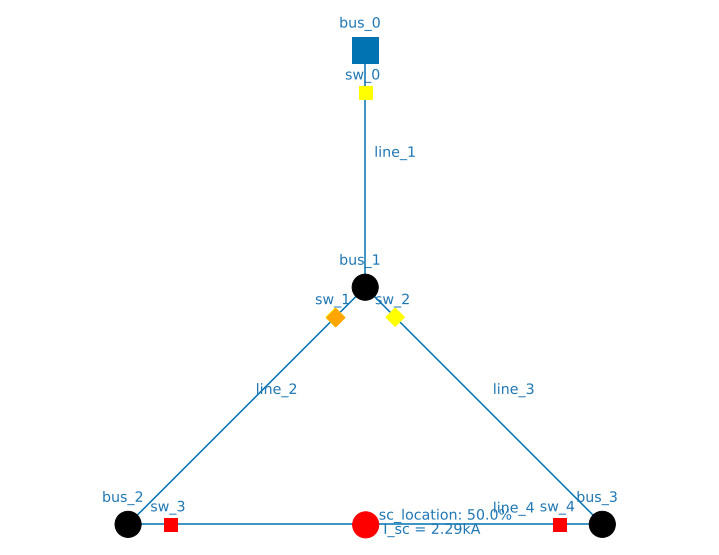

In [6]:
trip_decisions=doc_protection.run_fault_scenario_doc(net, sc_line_idx =4,sc_location = 0.5,
                                         timegrade=[0.07,0.5,0.3],relay_configuration=relay_configuration,
                                        plot_grid=True, i_t_plot=False)
# if needed the annotations can be disabled by 'plot_annotations=False'

# Create I-t Plot
* Plot showing relation between current and time (by default it will only plot the instaneous tripping switches and primary backup switches)


   Switch ID Switch type   Trip  Ikss [kA]  Trip time [s]
0          0         DOC   True   2.339756           1.10
1          1         DOC   True   0.550531           0.50
2          2         DOC   True   1.789225           0.07
3          3         DOC   True   0.550531           0.50
4          4         DOC  False   0.550531            inf


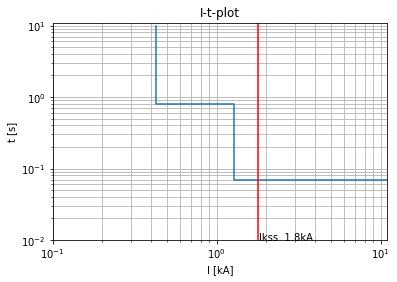

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [9]:
import matplotlib.pyplot as plt
trip_decisions=doc_protection.run_fault_scenario_doc(net, sc_line_idx =3,sc_location = 0.5,
                                         timegrade=[0.07,0.5,0.3],relay_configuration=relay_configuration,
                                                   plot_grid=False, i_t_plot=True)
plt.close()

Create I-t plot for the user defined switches using function create_I_t_plot

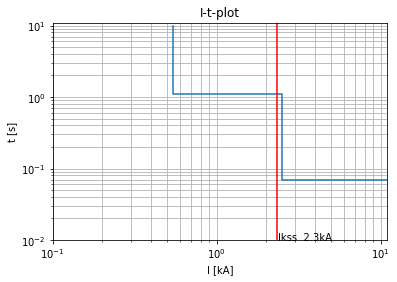

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [12]:
from pandaplan.core.protection.implementation.utility_functions import create_I_t_plot
import matplotlib.pyplot as plt
create_I_t_plot(trip_decisions,switch_id=[0])
plt.close()

# Additional features 

### Manual tripping time for each switches
doc fault scenario is capable to provide manual triiping time for each switches in the form a dataframe (replace timegrade by relay_trip_times)


In [18]:
import pandas as pd
relay_trip_times= pd.DataFrame({'switch_idx': [0,1,2,3,4,5,6],
                              't_gg': [0.07,0.07,0.07,0.07,0.07,0.07,0.06],
                              't_g':[0.5,0.8,1.1,1.4,1.7,2.0,2.3]})


In [19]:
trip_decisions=doc_protection.run_fault_scenario_doc(net, sc_line_idx =4,sc_location = 0.5,
                                         relay_trip_times=relay_trip_times,relay_configuration=relay_configuration,
                                                     plot_grid=False, i_t_plot=False)

### Varying DOC parameters
DOC fault scenario is capable to set  treshhold triping current for each switches by varying the default values in the following parameters from the default value
 - sc_fraction (float, 0.95) : Maximum possible extent to which the short circuit can be created on the line
 - overload_factor (float, 1.25):Allowable over loading on the line used to calculate the backup pick up current
 - ct_current_factor (float, 1.2): Current mutiplication factor to define the backup pick up current
 - safety_factor (float, 1): Safety limit for the instantaneous pick up currents


use_bus_geodata is automatically set to True, since net.line_geodata is empty.


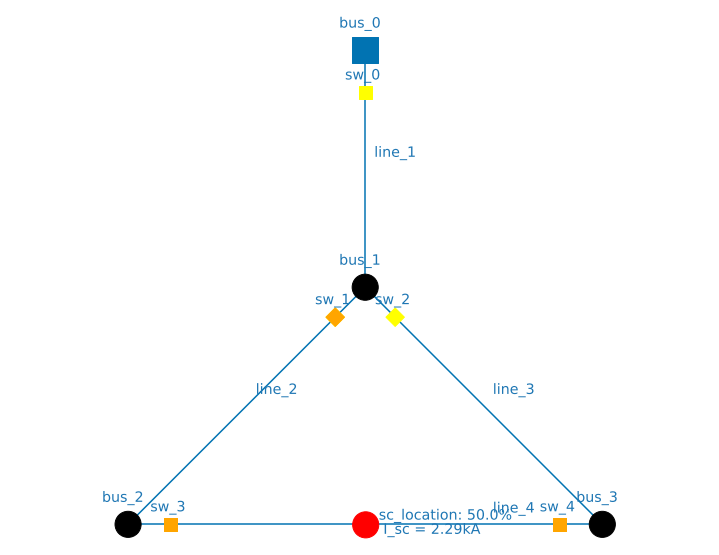

In [20]:
trip_decisions=doc_protection.run_fault_scenario_doc(net, sc_line_idx =4,sc_location = 0.5,
                    timegrade=[0.07,0.5,0.3],sc_fraction=0.9,relay_configuration=relay_configuration,overload_factor=1.5,
                    ct_current_factor=2,safety_factor=1.5,plot_grid=True, plot_annotations=True,i_t_plot=False)

### Manual tripping current for each switches
Instead of varying the OC parametrs, userd can defne pickup current for each switches in the form of dataframe


In [22]:
relay_trip_currents= pd.DataFrame({'Relay ID': [0,1,2,3,4,5,6],
                              'Igg': [2.2,2.3,2.1,2.5,1.2,0.9,1.7],
                              'Ig':[0.8,0.7,0.7,0.8,0.8,0.8,0.9]})

trip_decisions=doc_protection.run_fault_scenario_doc(net, sc_line_idx =4,sc_location = 0.5,timegrade=[0.07,0.4,0.3],
                                                     relay_configuration=relay_configuration,plot_grid=False, i_t_plot=False)